# Equations with first order term

In [1]:
# ![ -d /var/colab ] && pip install poetry
# ![ -d /var/colab ] && pip install git+https://github.com/gbonnet1/notebooks.git

In [2]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation import Dense2, Sparse
from agd.AutomaticDifferentiation.Optimization import newton_root

In [3]:
d = 2

In [4]:
if d == 2:
    cd = 1
    mu = 3
    nu = 1 / 10
elif d == 3:
    cd = 1 / (2 * np.sqrt(3))
    mu = 20
    nu = 1 / 10
else:
    raise ValueError(f"Invalid dimension: {d}")

In [5]:
domain = Domain.Union(Domain.Ball(center=d * [0]), Domain.Box(sides=d * [(0, 1)]))

In [6]:
def omega0(x):
    if d == 2:
        return np.stack([np.cos(np.pi * x[1]), np.sin(np.pi * x[1])])
    elif d == 3:
        return np.stack(
            [
                np.cos(np.pi * x[1]),
                np.sin(np.pi * x[1]) * np.cos(np.pi * x[2]),
                np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]),
            ]
        )
    else:
        raise ValueError(f"Invalid dimension: {d}")


def omega(x):
    return (2 - np.cos(np.pi * x[0])) * omega0(x)


def D(x):
    return (
        mu
        * (2 + np.cos(np.pi * x[0]))
        * (
            nu * lp.identity(x.shape[1:])
            + (1 - nu) * lp.outer(omega0(x / 2), omega0(x / 2))
        )
    )

In [7]:
h_max = cd * mu * nu / 3

In [8]:
def grid(h):
    return np.stack(
        np.meshgrid(*(d * [np.arange(-h * np.floor(1 / h), 1, h)]), indexing="ij")
    )

In [9]:
def u1(x):
    return 1 / 10 * lp.dot_VV(x, x) ** 2


def u2(x):
    return 0.6 * np.maximum(0, np.sqrt(lp.dot_VV(x, x)) - 0.2) ** 2.5


def u3(x):
    return np.sqrt(d - lp.dot_VV(x, x))

In [10]:
def EqLinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return -lp.dot_VV(omega(x), du) - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeLinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))

    coef_min = np.min(coef)
    offsets_norm2 = lp.dot_VV(offsets, offsets)
    offsets_max2 = np.max(np.where(coef < 1e-13, 0, offsets_norm2))
    print(f"h: {bc.gridscale}, c: {coef_min}, e2: {offsets_max2}")

    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    return np.where(
        bc.interior,
        -lp.dot_VAV(omega(x), lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
        - lp.dot_VV(coef, d2u)
        - f,
        u - bc.grid_values,
    )


def SolveLinear(x, f, bc):
    u = Sparse.identity(constant=np.zeros(x.shape[1:]))
    residue = SchemeLinear(u, x, f, bc)
    return residue.solve()

h: 0.012499999999999956, c: 1.5550433743659944e-14, e2: 5


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


h: 0.012499999999999956, c: 1.5550433743659944e-14, e2: 5
h: 0.012499999999999956, c: 1.5550433743659944e-14, e2: 5


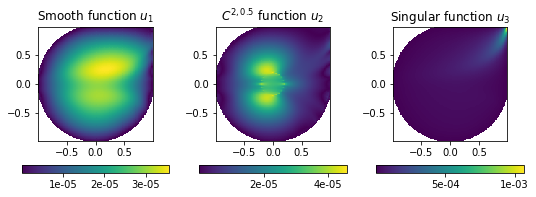

In [11]:
if d == 2:
    plt.figure(figsize=(9, 3))

    for i, (u_func, title) in enumerate(
        [
            (u1, "Smooth function $u_1$"),
            (u2, "$C^{2, 0.5}$ function $u_2$"),
            (u3, "Singular function $u_3$"),
        ]
    ):
        x = grid(h_max / 8)
        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx = SolveLinear(x, f, bc)

        plt.subplot(131 + i, aspect="equal")
        plt.title(title)
        im = plt.pcolormesh(*x, np.where(bc.interior, np.abs(u - u_approx), np.nan))
        plt.colorbar(im, orientation="horizontal", format="%.0e")

    plt.savefig("linear-error-2d.png")
    plt.show()

h: 0.09999999999999998, c: 1.4817236578672535e-15, e2: 5
h: 0.08705505632961241, c: 4.750322671851321e-16, e2: 5
h: 0.07578582832551994, c: 1.4141101079294547e-15, e2: 5
h: 0.06597539553864473, c: 9.42224108424067e-16, e2: 5
h: 0.057434917749851766, c: 4.721565146565345e-16, e2: 5
h: 0.050000000000000044, c: 2.8599560570740983e-15, e2: 5
h: 0.043527528164806206, c: 4.750322671851321e-16, e2: 5
h: 0.03789291416275997, c: 1.4141101079294547e-15, e2: 5
h: 0.03298769776932231, c: 6.124456704756435e-15, e2: 5
h: 0.028717458874925827, c: 7.554504234504552e-15, e2: 5
h: 0.025000000000000022, c: 2.833882550382289e-15, e2: 5
h: 0.021763764082403103, c: 4.718508822496139e-16, e2: 5
h: 0.018946457081379986, c: 2.3568501798824246e-15, e2: 5
h: 0.01649384888466121, c: 8.008904921604566e-15, e2: 5
h: 0.01435872943746297, c: 9.42121894226786e-15, e2: 5
h: 0.012499999999999956, c: 1.5550433743659944e-14, e2: 5
h: 0.09999999999999998, c: 1.4817236578672535e-15, e2: 5
h: 0.08705505632961241, c: 4.750322

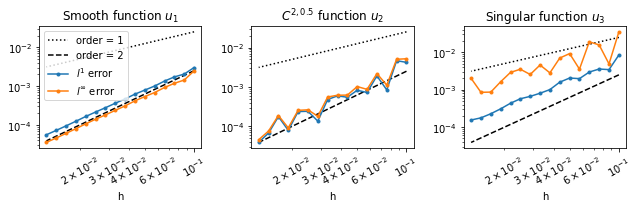

In [12]:
plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    if d == 2:
        h = h_max / 2 ** np.arange(0, 3.2, 0.2)
    elif d == 3:
        h = h_max / 2 ** np.arange(0, 2.2, 0.2)
    else:
        raise ValueError(f"Invalid dimension: {d}")

    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    for j in range(len(h)):
        x = grid(h[j])
        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx = SolveLinear(x, f, bc)

        err_l1[j] = h[j] ** d * np.sum(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")
    plt.loglog(h, h / 4, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 4, "k--", label="order = 2")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig(f"linear-convergence-{d}d.png")
plt.show()

In [13]:
def EqNonlinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return 1 / 2 * lp.dot_VV(du, du) - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeNonlinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))
    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    p = lp.dot_AV(lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
    return np.where(
        bc.interior,
        1 / 2 * lp.dot_VV(p, p) - lp.dot_VV(coef, d2u) - f,
        u - bc.grid_values,
    )


def SolveNonlinear(x, f, bc):
    return newton_root(SchemeNonlinear, lp.dot_VV(x, x), params=(x, f, bc))

Iteration: 1  Residue norm: 737146.0476986077
Iteration: 2  Residue norm: 107941.27904378442
Iteration: 3  Residue norm: 4606.181598721251
Iteration: 4  Residue norm: 11.206291008371423
Iteration: 5  Residue norm: 0.0006642161629120125
Iteration: 6  Residue norm: 8.315126365232572e-12
Target residue reached. Terminating.


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Iteration: 1  Residue norm: 437078.6314613678
Iteration: 2  Residue norm: 49821.609530674184
Iteration: 3  Residue norm: 1081.8599140653303
Iteration: 4  Residue norm: 0.9347988415903465
Iteration: 5  Residue norm: 4.639535610806433e-06
Iteration: 6  Residue norm: 2.020783540501725e-11
Target residue reached. Terminating.
Iteration: 1  Residue norm: 2905.194085659953
Iteration: 2  Residue norm: 431.31446167783525
Iteration: 3  Residue norm: 7.3487912498301
Iteration: 4  Residue norm: 0.001617828832536361
Iteration: 5  Residue norm: 1.3502798879017064e-10
Target residue reached. Terminating.


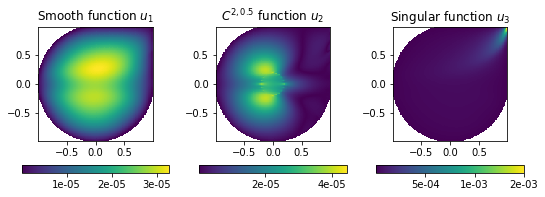

In [14]:
if d == 2:
    plt.figure(figsize=(9, 3))

    for i, (u_func, title) in enumerate(
        [
            (u1, "Smooth function $u_1$"),
            (u2, "$C^{2, 0.5}$ function $u_2$"),
            (u3, "Singular function $u_3$"),
        ]
    ):
        x = grid(h_max / 8)
        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx = SolveNonlinear(x, f, bc)

        plt.subplot(131 + i, aspect="equal")
        plt.title(title)
        im = plt.pcolormesh(*x, np.where(bc.interior, np.abs(u - u_approx), np.nan))
        plt.colorbar(im, orientation="horizontal", format="%.0e")

    plt.savefig("nonlinear-error-2d.png")
    plt.show()

Iteration: 1  Residue norm: 749.403232888894
Iteration: 2  Residue norm: 70.01712403239084
Iteration: 3  Residue norm: 0.888507336985521
Iteration: 4  Residue norm: 0.0001509439812910074
Iteration: 5  Residue norm: 4.340083847864662e-12
Target residue reached. Terminating.
Iteration: 1  Residue norm: 2650.6054919218845
Iteration: 2  Residue norm: 180.47296142588905
Iteration: 3  Residue norm: 2.9161119080182165
Iteration: 4  Residue norm: 0.0043080889858353455
Iteration: 5  Residue norm: 1.9934554451594977e-08
Iteration: 6  Residue norm: 1.1901590823981678e-13
Target residue reached. Terminating.
Iteration: 1  Residue norm: 13994.01229589078
Iteration: 2  Residue norm: 3042.00570262719
Iteration: 3  Residue norm: 447.01302998551137
Iteration: 4  Residue norm: 19.302778330835196
Iteration: 5  Residue norm: 0.043103622096501315
Iteration: 6  Residue norm: 2.1686416440402922e-07
Iteration: 7  Residue norm: 3.5704772471945034e-13
Target residue reached. Terminating.
Iteration: 1  Residue n

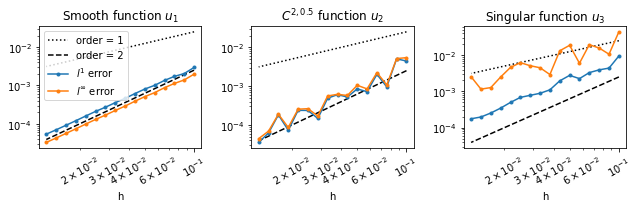

In [15]:
plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    if d == 2:
        h = h_max / 2 ** np.arange(0, 3.2, 0.2)
    elif d == 3:
        h = h_max / 2 ** np.arange(0, 2.2, 0.2)
    else:
        raise ValueError(f"Invalid dimension: {d}")

    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    for j in range(len(h)):
        x = grid(h[j])
        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx = SolveNonlinear(x, f, bc)

        err_l1[j] = h[j] ** d * np.sum(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")
    plt.loglog(h, h / 4, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 4, "k--", label="order = 2")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig(f"nonlinear-convergence-{d}d.png")
plt.show()